# Occupancy detection - A multivariate time series example

In this tutorial, you will learn how to apply getML to multivariate time series.

Our use case is a public domain data set for predicting room occupancy from sensor data. The results achieved using getML outperform all published results on this data set. Note that this is not only a neat use case for machine learning algorithms, but a real-world application with tangible consequences: If room occupancy is known with sufficient certainty, it can be applied to the control systems of a building. Such as system can reduce the energy consumption by [up to 50 %](https://ieeexplore.ieee.org/document/7566062).


**Introduction**

Usually, getML is considered to be a tool for feature engineering and machine learning on relational data sets. How can we apply it to (multivariate) time series?

The key is a _self-join_. Instead of creating features by merging and aggregating peripheral tables in a relational data model, for a time-series, we perform the same operations on the population table itself. This results in features like these:

* Aggregations over time, such as the average value of some column for the last 3 days.

* Seasonal effects, such as today is a Wednesday, so let's get the average value for the last four Wednesdays.

* Lag variables, such as get the value of some column from two hours ago.

Using getML's algorithms for relational learning, we can extract all of these features automatically. Having created a flat table of such features, we can then apply state-of-the-art machine learning algorithms, like xgboost. As you will see in this example, this performs better than traditional time series analysis.

The present analysis is based on a public domain time series dataset. It is available in the [UC Irvine Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+). The challenge is straightforward: We want to predict whether an office room is occupied at a given moment in time using sensor data. The data is measured about once a minute. Ground-truth occupancy was obtained from time-stamped pictures. The available columns are

* Date, year-month-day hour:minute:second
* Temperature, in Celsius
* Relative Humidity, %
* Light, in Lux
* CO2, in ppm
* Humidity Ratio, Derived quantity from temperature and relative humidity, in kgwater-vapor/kg-air
* Occupancy, 0 or 1, 0 for not occupied, 1 for occupied status

As a reference and benchmark, we use [this paper](http://www.worldresearchlibrary.org/up_proc/pdf/568-148612088816-20.pdf):

* Accurate occupancy detection of an office room from light, temperature, humidity and CO2 measurements using statistical learning models. Luis M. Candanedo, Veronique Feldheim. Energy and Buildings. Volume 112, 15 January 2016, Pages 28-39.

The authors apply various artifical neural networks algorithms to the data set at hand and achieved accuracies between 80.324% (batch back algorithm) and 99.061% (limited memory quasi-Newton algorithm).

### A web frontend for getML

The getML monitor is a frontend built to support your work with getML. The getML monitor displays information such as the imported data frames, trained pipelines and allows easy data and feature exploration. You can launch the getML monitor [here](http://localhost:1709).

### Where is this running?

Your getML live session is running inside a docker container on [mybinder.org](https://mybinder.org/), a service built by the Jupyter community and funded by Google Cloud, OVH, GESIS Notebooks and the Turing Institute. As it is a free service, this session will shut down after 10 minutes of inactivity.

# Analysis

Let's get started with the analysis and set-up your session:

In [1]:
import os
import numpy as np
import pandas as pd
from urllib import request
from IPython.display import Image, Markdown
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline  

import getml

print(f"getML API version: {getml.__version__}\n")

getml.engine.set_project('occupancy')

getML API version: 0.12.0-datasets.3

Creating new project 'occupancy'


## 1. Loading data


The data set can be downloaded directly from GitHub. It is conveniently separated into a training, a validation and a testing set. This allows us to directly benchmark our results against the results of the original paper later.

In [2]:
directory = '.temp/'

fnames = [
    'datatraining.txt',
    'datatest.txt',
    'datatest2.txt'
]

if not os.path.exists(directory):
    os.makedirs(directory)

for fname in fnames:
    if not os.path.exists(directory + fname):
        fname, res = request.urlretrieve(
            "https://raw.githubusercontent.com/LuisM78/Occupancy-detection-data/master/" + fname, 
            directory + fname
        )


The data file contain the row number Because the data files are not valid CSV, we first load them into pandas before uploading them to the getML engine.

In [3]:
datatraining_pandas = pd.read_csv(directory + 'datatraining.txt')
datatest_pandas = pd.read_csv(directory + 'datatest.txt')
datatest2_pandas = pd.read_csv(directory + 'datatest2.txt')

data_train = getml.data.DataFrame.from_pandas(datatraining_pandas, name='data_train')
data_validate = getml.data.DataFrame.from_pandas(datatest_pandas, name='data_validate')
data_test = getml.data.DataFrame.from_pandas(datatest2_pandas, name='data_test')

The training set looks like this:

In [4]:
data_train

Name,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,date
Role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_string
0,23.18,27.272,426,721.25,0.00479299,1,2015-02-04 17:51:00
1,23.15,27.2675,429.5,714,0.00478344,1,2015-02-04 17:51:59
2,23.15,27.245,426,713.5,0.00477946,1,2015-02-04 17:53:00
3,23.15,27.2,426,708.25,0.00477151,1,2015-02-04 17:54:00
4,23.1,27.2,426,704.5,0.00475699,1,2015-02-04 17:55:00
,...,...,...,...,...,...,...
8138,21.05,36.0975,433,787.25,0.00557871,1,2015-02-10 09:29:00
8139,21.05,35.995,433,789.5,0.00556273,1,2015-02-10 09:29:59
8140,21.1,36.095,433,798.5,0.00559564,1,2015-02-10 09:30:59


We also assign roles to each column. To learn more about what roles do and why we need them, check out the [official documentation](https://docs.getml.com/latest/user_guide/annotating_data/annotating_data.html).

In [5]:
for df in [data_train, data_validate, data_test]:
    df.set_role(['Occupancy'], getml.data.roles.target)
    df.set_role(['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio'], getml.data.roles.numerical)
    df.set_role(['date'], getml.data.roles.time_stamp)
    
data_train

Name,date,Occupancy,Temperature,Humidity,Light,CO2,HumidityRatio
Role,time_stamp,target,numerical,numerical,numerical,numerical,numerical
Unit,"time stamp, comparison only",,,,,,
0,2015-02-04T17:51:00.000000Z,1,23.18,27.272,426,721.25,0.00479299
1,2015-02-04T17:51:59.000000Z,1,23.15,27.2675,429.5,714,0.00478344
2,2015-02-04T17:53:00.000000Z,1,23.15,27.245,426,713.5,0.00477946
3,2015-02-04T17:54:00.000000Z,1,23.15,27.2,426,708.25,0.00477151
4,2015-02-04T17:55:00.000000Z,1,23.1,27.2,426,704.5,0.00475699
,...,...,...,...,...,...,...
8138,2015-02-10T09:29:00.000000Z,1,21.05,36.0975,433,787.25,0.00557871
8139,2015-02-10T09:29:59.000000Z,1,21.05,35.995,433,789.5,0.00556273


## 2. Predictive modelling

We use a [MultirelModel](https://docs.getml.com/latest/api/getml.models.MultirelModel.html) for generating the features and an [XGBoostClassifier](https://docs.getml.com/latest/api/getml.predictors.XGBoostClassifier.html#getml.predictors.XGBoostClassifier) for feature selection and prediction.

We do not spend much effort on the hyperparameters and largely go with the default values. The only exception is that we add some regularization to the XGBoostClassifiers.

We choose to consider data within the last 10 minutes for creating our features.

In [6]:
# Our forecast horizon is 0.
# We do not predict the future, instead we infer 
# the present state from current and past sensor data.
horizon = 0.0

# We do not allow the time series features
# to use target values from the past.
# (Otherwise, we would need the horizon to
# be greater than 0.0).
allow_lagged_targets = False

# We want our time series features to only use
# data from the last 15 minutes
memory = getml.data.time.minutes(15)

feature_learner = getml.feature_learning.MultirelTimeSeries(
        ts_name="date",
        horizon=horizon,
        memory=memory,
        allow_lagged_targets=allow_lagged_targets,
        num_features=30,
        num_threads=1,
        loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss
)

predictor = getml.predictors.XGBoostClassifier(reg_lambda=500)

pipe = getml.pipeline.Pipeline(
    tags=["memory=15", "no ts_name", "multirel"],
    feature_learners=[feature_learner],
    predictors=[predictor]
)

pipe

Pipeline(feature_learners=['MultirelTimeSeries'], feature_selectors=[], 
         include_categorical=False, peripheral=[], population='POPULATION', 
         predictors=['XGBoostClassifier'], 
         tags=['memory=15', 'no ts_name', 'multirel'], 
         share_selected_features=0.5)

`.check(...)` will be automatically called by `.fit(...)`. But it is always a good idea to call `.check(...)` separately before fitting, so we still have time for some last-minute fixes.

In [7]:
pipe.check(data_train)

Checking data model...
OK.


We now fit the model. This should take well under one minute, depending on your computer.

In [8]:
pipe.fit(data_train)

Checking data model...
OK.

MultirelModel: Training features...
[========================================] 100%

MultirelModel: Building features...
[========================================] 100%

XGBoost: Training as predictor...
[========================================] 100%

Trained pipeline.
Time taken: 0h:0m:22.157705



Pipeline(feature_learners=['MultirelTimeSeries'], feature_selectors=[], 
         include_categorical=False, peripheral=[], population='POPULATION', 
         predictors=['XGBoostClassifier'], 
         tags=['memory=15', 'no ts_name', 'multirel'], 
         share_selected_features=0.5)

url: /user/getml-getml-demo-8d9mvmsx/proxy/1709/getpipeline/4s28sM/0/

Let's see how well we did by scoring the model.

In [9]:
in_sample = pipe.score(data_train)

out_of_sample = pipe.score(data_test)

print("""
Accuracy (training): {:.5f}
AUC (training): {:.5f}\n
Accuracy (testing): {:.5f}
AUC (testing): {:.5f}
""".format(
    in_sample['accuracy'][0], 
    in_sample['auc'][0],
    out_of_sample['accuracy'][0], 
    out_of_sample['auc'][0])
)


MultirelModel: Building features...
[========================================] 100%


MultirelModel: Building features...
[========================================] 100%


Accuracy (training): 0.99398
AUC (training): 0.99857

Accuracy (testing): 0.99098
AUC (testing): 0.99657



In the [original paper](http://www.worldresearchlibrary.org/up_proc/pdf/568-148612088816-20.pdf), the authors tried several approaches. The best out-of-sample values of all the approaches they tried are the following:

* Accuracy (testing): 0.99061
* AUC (testing): 0.99574

Note that our results outperform the best approach from the original paper, both in terms of accuracy as well as AUC. 
This demonstrates how powerful getML's relational learning approach is also a powerful tool for time series.

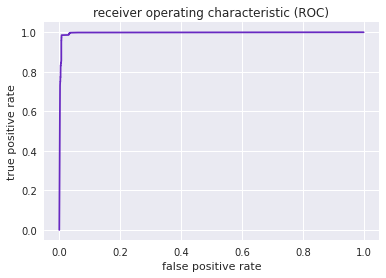

In [10]:
# Refers to the data from the last time
# we called .score(...).
fpr, tpr = pipe.metrics.roc_curve()

plt.plot(fpr, tpr, color='#6829c2')

plt.title("receiver operating characteristic (ROC)")
plt.grid(True)
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

plt.show()

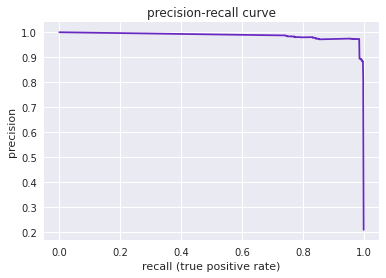

In [11]:
# Refers to the data from the last time
# we called .score(...).
recall, precision = pipe.metrics.precision_recall_curve()

plt.plot(recall, precision, color='#6829c2')

plt.title("precision-recall curve")
plt.grid(True)
plt.xlabel("recall (true positive rate)")
plt.ylabel("precision")

plt.show()

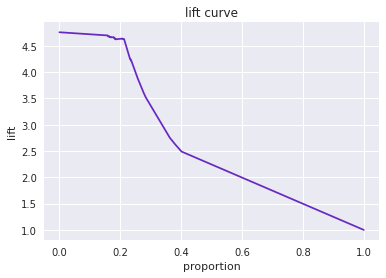

In [12]:
# Refers to the data from the last time
# we called .score(...).
proportion, lift = pipe.metrics.lift_curve()

plt.plot(proportion, lift, color='#6829c2')

plt.title("lift curve")
plt.grid(True)
plt.xlabel("proportion")
plt.ylabel("lift")

plt.show()

### Studying the features

It is always a good idea to study the features the relational learning algorithm has extracted. We can do so in the [feature view](https://docs.getml.com/latest/user_guide/getml_suite/monitor/models.html#feature-view) of the getML monitor. Open the monitor and select the models tab in the sidebar. You will see an overview over the trained pipelines. Select a pipeline to see the most essential summary plots. 

If you want to document them inside your notebook, here is how you can do that:

In [13]:
pipe.features.to_pandas()

,names,correlations,importances,target,sql
0,feature_1_1,0.927908,1.304166e-04,Occupancy,"CREATE TABLE ""FEATURE_1_1"" AS\nSELECT AVG( t2...."
1,feature_1_2,0.886662,3.994196e-04,Occupancy,"CREATE TABLE ""FEATURE_1_2"" AS\nSELECT AVG( t2...."
2,feature_1_3,0.903048,0.000000e+00,Occupancy,"CREATE TABLE ""FEATURE_1_3"" AS\nSELECT AVG( ( j..."
3,feature_1_4,0.978384,1.345563e-04,Occupancy,"CREATE TABLE ""FEATURE_1_4"" AS\nSELECT MIN( t2...."
4,feature_1_5,0.888704,1.370091e-02,Occupancy,"CREATE TABLE ""FEATURE_1_5"" AS\nSELECT AVG( t2...."
5,feature_1_6,0.887358,9.474699e-03,Occupancy,"CREATE TABLE ""FEATURE_1_6"" AS\nSELECT SUM( ( j..."
6,feature_1_7,0.957297,1.691924e-02,Occupancy,"CREATE TABLE ""FEATURE_1_7"" AS\nSELECT COUNT( *..."
7,feature_1_8,-0.946815,1.533828e-06,Occupancy,"CREATE TABLE ""FEATURE_1_8"" AS\nSELECT AVG( ( j..."
8,feature_1_9,-0.967972,8.501138e-08,Occupancy,"CREATE TABLE ""FEATURE_1_9"" AS\nSELECT AVG( ( j..."
9,feature_1_10,0.948280,7.919773e-04,Occupancy,"CREATE TABLE ""FEATURE_1_10"" AS\nSELECT SUM( t2..."


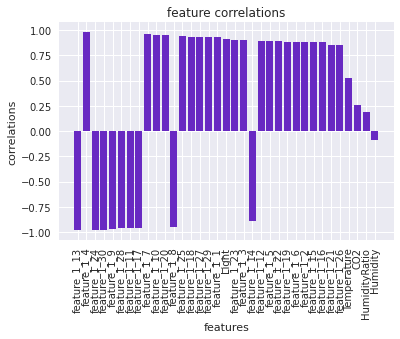

In [14]:
names, correlations = pipe.features.correlations()

plt.bar(names, correlations, color='#6829c2')

plt.title("feature correlations")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("correlations")
plt.xticks(rotation='vertical')

plt.show()

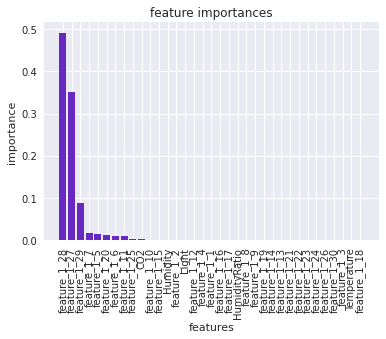

In [15]:
names, importances = pipe.features.importances()

plt.bar(names, importances, color='#6829c2')

plt.title("feature importances")
plt.grid(True)
plt.xlabel("features")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

The feature importance is calculated by XGBoost based on the improvement of the optimizing criterium at each split in the decision tree and is normalized to 100%. 

We first look at the most important feature. The names returned by feature importances are already sorted, so we can just index them, like this:

In [16]:
pipe.features.to_sql()[names[0]]

```sql
CREATE TABLE "FEATURE_1_28" AS
SELECT MAX( ( julianday( t1."date" ) - julianday( t2."date" ) ) * 86400.0 ) AS "feature_1_28",
       t1.rowid AS "rownum"
FROM "POPULATION" t1
LEFT JOIN "POPULATION" t2
ON 1 = 1
WHERE (
   ( ( t1."Light" > 371.789634 ) AND ( t1."CO2" > 477.106250 ) AND ( t2."Light" > 621.569620 ) AND ( t2."Light" <= 649.000000 ) )
OR ( ( t1."Light" > 371.789634 ) AND ( t1."CO2" <= 477.106250 ) AND ( t2."Temperature" > 20.229000 ) AND ( t2."CO2" <= 456.142857 ) )
OR ( ( t1."Light" <= 371.789634 ) AND ( datetime( t1."date" ) <= datetime( t2."date", '+13.935548 minutes' ) ) )
) AND datetime( t2."date" ) <= datetime( t1."date" )
AND ( datetime( t2."date", '+15.000000 minutes' ) > datetime( t1."date" ) OR datetime( t2."date", '+15.000000 minutes' ) IS NULL )
GROUP BY t1.rowid;
```

Let's check out the second most important feature.

In [17]:
pipe.features.to_sql()[names[1]]

```sql
CREATE TABLE "FEATURE_1_27" AS
SELECT MIN( t2."Light" ) AS "feature_1_27",
       t1.rowid AS "rownum"
FROM "POPULATION" t1
LEFT JOIN "POPULATION" t2
ON 1 = 1
WHERE (
   ( ( t2."CO2" > 481.714939 ) AND ( t2."HumidityRatio" <= 0.006437 ) AND ( t1."Light" > 94.548387 ) AND ( t2."Light" > 107.059361 ) )
OR ( ( t2."CO2" <= 481.714939 ) AND ( t2."HumidityRatio" > 0.002724 ) AND ( t2."Humidity" > 33.217308 ) )
OR ( ( t2."CO2" <= 481.714939 ) AND ( t2."HumidityRatio" <= 0.002724 ) AND ( t2."Temperature" <= 20.132286 ) )
) AND datetime( t2."date" ) <= datetime( t1."date" )
AND ( datetime( t2."date", '+15.000000 minutes' ) > datetime( t1."date" ) OR datetime( t2."date", '+15.000000 minutes' ) IS NULL )
GROUP BY t1.rowid;
```

This feature checks how long ago the light was last switched on.

These two features demonstrate the power of the getML feature learning algorithms. It is very unlikely to find these features using manual, trial-and-error based methods. The general structure of features found using such methods might be similar, but you would have had to put in much more effort while getting worse results.

When browsing through the remaining features, you will notice that some are columns directly taken from the original table, such as *Light* and *CO2*. But these columns are less correlated and less important than the features generated with the relational model based on self-join and upper time stamps.

## 3. Conclusion

This tutorial demonstrates that relational learning is a powerful tool for time series. We able to outperform the benchmarks for a scientific paper on a simple public domain time series data set using relatively little effort.

If you want to learn more about getML, check out the [official documentation](https://getml.com/product).

# Next Steps

This tutorial went through the basics of applying getML to time series. If you want to learn more about getML, here are some additional tutorials and articles that will help you:

__Tutorials:__
* [Disease lethality prediction: Feature engineering and the curse of dimensionality](atherosclerosis_demo.ipynb)
* [Loan default prediction: Introduction to relational learning](loans_demo.ipynb)
* [Traffic volume prediction: Feature engineering on multivariate time series](interstate94_demo.ipynb)


__User Guides__ (from our [documentation](https://docs.getml.com/latest/)):
* [Feature learning with Multirel](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#multirel)
* [Feature learning with Relboost](https://docs.getml.com/latest/user_guide/feature_engineering/feature_engineering.html#relboost)


While this tutorial focuses on the new aspects when working with getML, some more steps were required to prepare the raw data in its relational format. You will find the full analysis on Github in our [getml-examples](https://github.com/getml/getml-examples) repository.


# Get into contact

If you have any question schedule a [call with Alex](https://go.getml.com/meetings/alexander-uhlig/getml-demo), the co-founder of getML, or write us an [email](team@getml.com). Prefer a private demo of getML? Just contact us to make an appointment.